*0. Dependencies installation*

In [1]:
!pip install deep-translator scikit-learn transformers
!pip install pandas tiktoken huggingface_hub streamlit
!pip install tf-keras nltk matplotlib seaborn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


*1. Text Translation*
This cell uses the deep_translator library to translate text from English to Russian. The translate_text function performs the translation of the provided text into the target language, and the result is printed to verify its correctness.

In [2]:
from deep_translator import GoogleTranslator

def translate_text(text, target_language='ru'):
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    return translated_text

translated_text = translate_text("Hello, how are you?", 'ru')
print(translated_text)

Привет, как дела?


*2. Inspecting JSONL Files*
The inspect_jsonl function reads the first few lines from a JSONL file and loads them into a list of dictionaries. This step helps in reviewing the structure and content of the data before further processing.

In [3]:
import json

def inspect_jsonl(file_path, num_lines=1):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i < num_lines:
                data.append(json.loads(line))
            else:
                break
    return data

sample_data = inspect_jsonl('data/train.jsonl', num_lines=1)
print(json.dumps(sample_data, indent=2, ensure_ascii=False))

[
  {
    "phase": 1,
    "table_id": "1-1000181-1",
    "question": "Tell me what the notes are for South Australia ",
    "sql": {
      "sel": 5,
      "conds": [
        [
          3,
          0,
          "SOUTH AUSTRALIA"
        ]
      ],
      "agg": 0
    }
  }
]


*3. Loading, Translating, and Saving WikiSQL Data*
The load_wikisql_data function loads data from a JSONL file. Then, the data is translated into Russian, and the results are saved into a DataFrame. This is an essential step for preparing the data for model training.

In [4]:
import json
import os
import hashlib
from tqdm import tqdm
import pandas as pd
from deep_translator import GoogleTranslator

def load_wikisql_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_wikisql_data('data/train.jsonl')

def get_cache_key(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

def translate_text_with_cache(text, target_language='ru', cache_dir='translation_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    cache_key = get_cache_key(text)
    cache_file = os.path.join(cache_dir, f"{cache_key}.txt")
    
    if os.path.exists(cache_file):
        with open(cache_file, 'r', encoding='utf-8') as f:
            return f.read()
    
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    with open(cache_file, 'w', encoding='utf-8') as f:
        f.write(translated_text)
    
    return translated_text

data = []

for item in tqdm(train_data[:1000]):
    question_en = item['question']
    sql_data = item['sql']
    
    question_ru = translate_text_with_cache(question_en)
    
    data.append({
        'question_ru': question_ru,
        'question_en': question_en,
        'sel': sql_data['sel'],
        'conds': sql_data['conds'],
        'agg': sql_data['agg']
    })

df = pd.DataFrame(data)

df.to_csv('wikisql_processed_data.csv', index=False)

print(df.head())

print(df.info())

100%|██████████| 1000/1000 [00:00<00:00, 3692.87it/s]

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                     conds  agg  
0                [[3, 0, SOUTH AUSTRALIA]]    0  
1  [[5, 0, New series began in June 2011]]    0  
2                [[0, 0, South Australia]]    0  
3   [[0, 0, Australian Capital Territory]]    0  
4                            [[5, 0, CNG]]    

*4. Viewing Data*
This cell examines the structure and content of the created CSV file to ensure that the data has been saved correctly.

In [5]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

print(df.head())
print(df.info())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                       conds  agg  
0                [[3, 0, 'SOUTH AUSTRALIA']]    0  
1  [[5, 0, 'New series began in June 2011']]    0  
2                [[0, 0, 'South Australia']]    0  
3   [[0, 0, 'Australian Capital Territory']]    0  
4                            [[5, 0,

*5. Creating SQL Queries*
The reconstruct_sql_query function generates SQL queries based on data from the DataFrame using the provided table schema. This step is crucial for creating structured queries for analysis and model training.

In [6]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

df['conds'] = df['conds'].apply(eval)
print(df['conds'].apply(lambda c: all(len(cond) == 3 for cond in c)).value_counts())

table_schema = {
    "columns": ["column1", "column2", "column3", "column4", "column5", "column6", "column7", "column8", "column9", "column10", "column11", "column12", "column13"]
}

def reconstruct_sql_query(sel, conds, agg, table_schema):
    columns = table_schema['columns']
    agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]

    sel_col = columns[sel] if 0 <= sel < len(columns) else "unknown_column"
    
    agg_func = agg_funcs[agg] if 0 <= agg < len(agg_funcs) else ""
    select_part = f"SELECT {agg_func}({sel_col})" if agg_func else f"SELECT {sel_col}"
    
    cond_parts = []
    for cond in conds:
        if len(cond) != 3:
            continue
        col_index, op, value = cond
        col_name = columns[col_index] if 0 <= col_index < len(columns) else "unknown_column"
        if isinstance(value, str):
            value = f"'{value}'"
        cond_parts.append(f"{col_name} = {value}")
    
    where_part = " AND ".join(cond_parts)
    where_clause = f"WHERE {where_part}" if where_part else ""
    
    query = f"{select_part} FROM table_name {where_clause}"
    
    return query

df['sql_query'] = df.apply(lambda row: reconstruct_sql_query(row['sel'], row['conds'], row['agg'], table_schema), axis=1)
print(df['sql_query'].head())

print(df['sel'].unique())
print(df['conds'].apply(lambda c: [x[0] for x in c]).explode().unique())

invalid_indices = df[(df['sel'] >= len(table_schema['columns'])) | (df['sel'] < 0) |
                      df['conds'].apply(lambda c: any(x[0] >= len(table_schema['columns']) or x[0] < 0 for x in c))]
print(invalid_indices)

conds
True    1000
Name: count, dtype: int64
0    SELECT column6 FROM table_name WHERE column4 =...
1    SELECT column5 FROM table_name WHERE column6 =...
2    SELECT column3 FROM table_name WHERE column1 =...
3    SELECT column2 FROM table_name WHERE column1 =...
4    SELECT COUNT(column4) FROM table_name WHERE co...
Name: sql_query, dtype: object
[ 5  4  2  1  3  0  6  9  7 10  8]
[3 5 0 2 1 4 10 6 8 nan 7 11 12 9]
Empty DataFrame
Columns: [question_ru, question_en, sel, conds, agg, sql_query]
Index: []


*6. Data Analysis*
Various plots are used to analyze the distribution of question lengths and types of SQL queries. This helps in understanding data distribution and identifying potential anomalies.

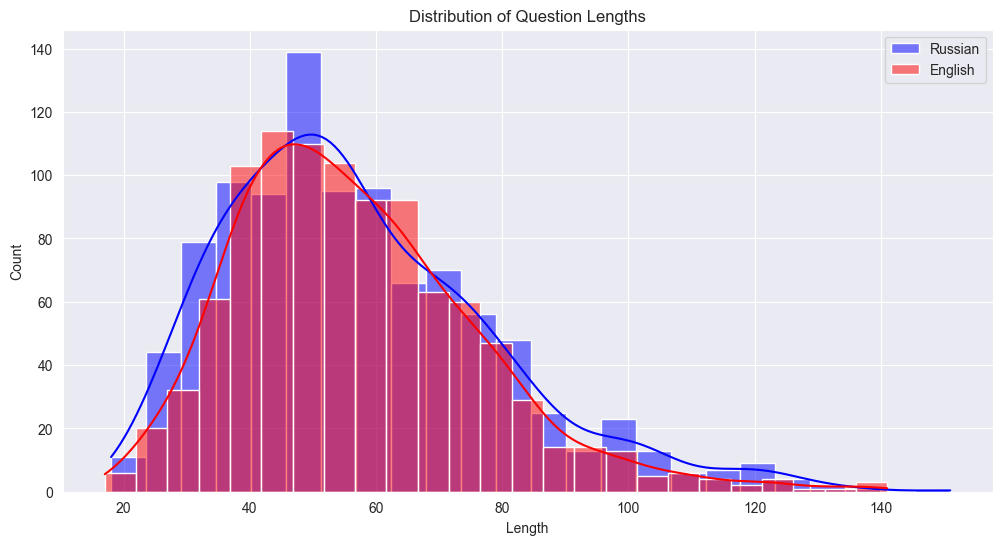

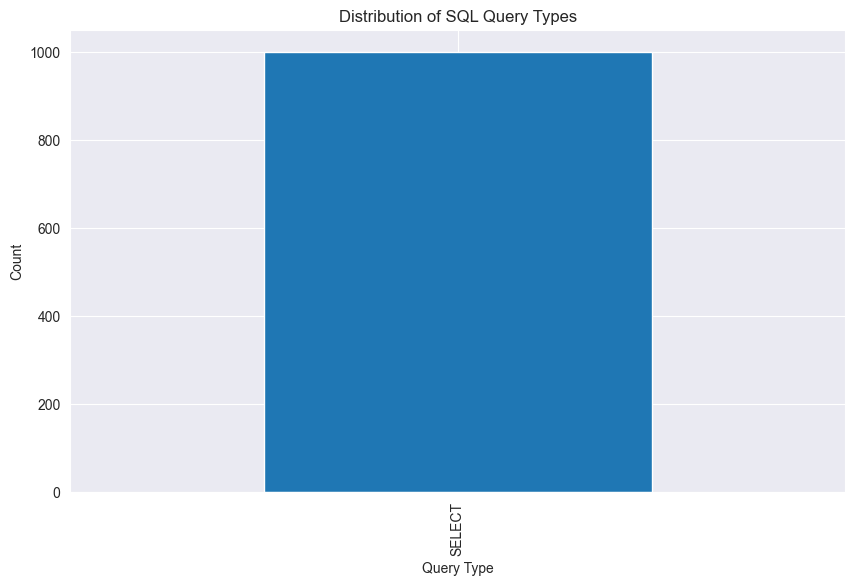

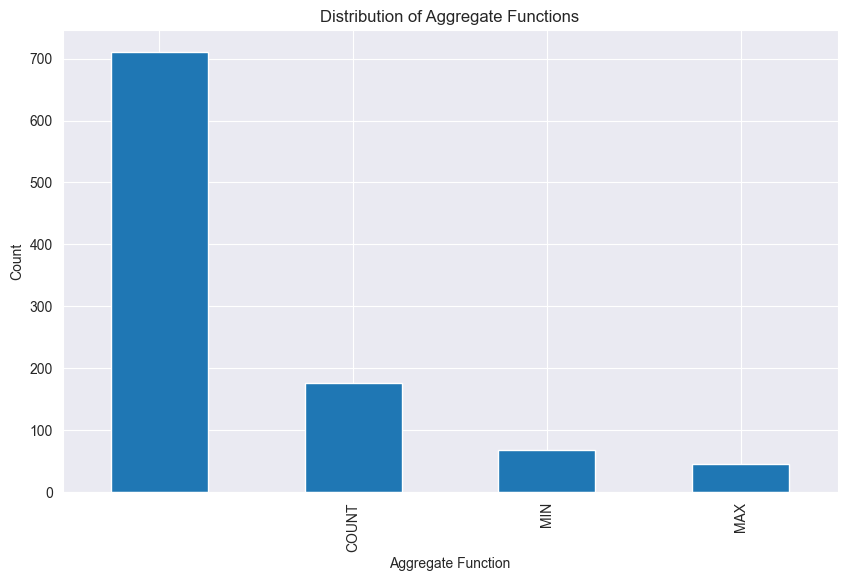

             sel         agg  question_ru_length  question_en_length
count  1000.0000  1000.00000         1000.000000         1000.000000
mean      2.9900     0.71000           57.196000           56.753000
std       2.2228     1.18292           21.666403           19.401609
min       0.0000     0.00000           18.000000           17.000000
25%       1.0000     0.00000           41.000000           43.000000
50%       3.0000     0.00000           54.000000           54.000000
75%       4.0000     1.00000           69.250000           68.000000
max      10.0000     3.00000          151.000000          141.000000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df['question_ru_length'] = df['question_ru'].str.len()
df['question_en_length'] = df['question_en'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='question_ru_length', kde=True, color='blue', label='Russian')
sns.histplot(data=df, x='question_en_length', kde=True, color='red', label='English')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length')
plt.legend()
plt.show()

df['query_type'] = df['sql_query'].apply(lambda x: x.split()[0])
plt.figure(figsize=(10, 6))
df['query_type'].value_counts().plot(kind='bar')
plt.title('Distribution of SQL Query Types')
plt.xlabel('Query Type')
plt.ylabel('Count')
plt.show()

agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]
df['agg_func'] = df['agg'].map(lambda x: agg_funcs[x] if x < len(agg_funcs) else "UNKNOWN")
plt.figure(figsize=(10, 6))
df['agg_func'].value_counts().plot(kind='bar')
plt.title('Distribution of Aggregate Functions')
plt.xlabel('Aggregate Function')
plt.ylabel('Count')
plt.show()

print(df.describe())

*7. Text Preprocessing*
The preprocess_text function performs text cleaning and tokenization for Russian text, removing stop words. This step is necessary for preparing the text for vectorization.

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['question_ru_processed'] = df['question_ru'].apply(preprocess_text)

print(df[['question_ru', 'question_ru_processed']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                               question_ru_processed  
0        расскажите какие примечания южной австралии  
1              текущий сериал начался июне 2011 года  
2                             формат южной австралии  
3  назовите цвет фона австралийской столичной тер...  
4  сколько топливо двигателей сжатым природным газом  


*8. Splitting Data*
Data is split into training and testing sets using train_test_split, allowing the model to be trained on one part of the data and evaluated on another.

In [9]:
from sklearn.model_selection import train_test_split

X = df['question_ru_processed']
y = df['sql_query']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 800
Test set size: 200


*9. Vectorizing Text*
Texts are transformed into numerical vectors using TfidfVectorizer, which is required for machine learning model training.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

*10. Training Logistic Regression*
A logistic regression model is trained on the vectorized data. This model is used for an initial assessment of classification performance.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train_vectorized, y_train)

y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


                                                                                                              precision    recall  f1-score   support

      SELECT COUNT(column1) FROM table_name WHERE column10 = 'BGS' AND column8 = 'ACGS' AND column2 = 'ACGS'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = '"Conference Call"'       0.00      0.00      0.00       1.0
                         SELECT COUNT(column1) FROM table_name WHERE column2 = 'Bosch Spark Plug Grand Prix'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = 'Natalia Raskokoha'       0.00      0.00      0.00       1.0
                                               SELECT COUNT(column1) FROM table_name WHERE column3 = '17.72'       0.00      0.00      0.00       1.0
                                            SELECT COUNT(column1) FROM table_name WHERE column5 = '

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

*11. Training Data Information*
Information about the classes in the training set is displayed to ensure that the data is balanced.

In [12]:
print(y_train.nunique())
print(y_train.value_counts())

782
sql_query
SELECT MIN(column2) FROM table_name                                   4
SELECT MAX(column2) FROM table_name                                   3
SELECT column8 FROM table_name WHERE column3 = '2R'                   2
SELECT column3 FROM table_name WHERE column2 = 'French Grand Prix'    2
SELECT column7 FROM table_name WHERE column5 = 'Jim Pugh'             2
                                                                     ..
SELECT column3 FROM table_name WHERE column1 = '2053'                 1
SELECT column1 FROM table_name WHERE column5 = 'D5244 T7'             1
SELECT column5 FROM table_name WHERE column2 = 'Zeltweg Airfield'     1
SELECT column6 FROM table_name WHERE column4 = 'Mike Hawthorn'        1
SELECT column5 FROM table_name WHERE column1 = 12                     1
Name: count, Length: 782, dtype: int64


*12. Extracting SQL Components*
The extract_components function splits SQL queries into parts, such as SELECT and WHERE. This allows for additional analysis at the component level.

In [13]:
def extract_components(sql):
    select = sql.split('FROM')[0].strip()
    where = sql.split('WHERE')[-1].strip() if 'WHERE' in sql else ''
    return select, where

df['select'], df['where'] = zip(*df['sql_query'].apply(extract_components))

*13. Training Random Forest*
A random forest model is trained on the same vectorized data as the logistic regression model. This can help improve prediction quality with a more complex model.

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

*14. Classifying SQL Queries*
The categorize_sql function classifies SQL queries by type. A new column in the DataFrame is created with these categories, and the data is split again.

In [15]:
from sklearn.preprocessing import LabelEncoder

def categorize_sql(query):
    if 'SELECT' in query and 'WHERE' in query:
        return 'SELECT_WITH_WHERE'
    elif 'SELECT' in query:
        return 'SELECT_ONLY'
    else:
        return 'OTHER'

df['sql_category'] = df['sql_query'].apply(categorize_sql)

le = LabelEncoder()
y = le.fit_transform(df['sql_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*15. Data Augmentation*
Introduce variations to the text data using noise and back translation to make the model more robust.

In [16]:
import hashlib
import os

def get_cache_key(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

In [17]:
import numpy as np

def add_noise(text, noise_level=0.1):
    chars = list(text)
    num_noisy_chars = int(len(chars) * noise_level)
    indices = np.random.choice(len(chars), num_noisy_chars, replace=False)
    
    for index in indices:
        chars[index] = np.random.choice(list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
    
    return ''.join(chars)

In [18]:
def add_noise_with_cache(text, noise_level=0.1, cache_dir='noise_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    cache_key = f"{get_cache_key(text)}_{noise_level}"
    cache_file = os.path.join(cache_dir, f"{cache_key}.txt")
    
    if os.path.exists(cache_file):
        with open(cache_file, 'r', encoding='utf-8') as f:
            return f.read()
    
    noisy_text = add_noise(text, noise_level)
    with open(cache_file, 'w', encoding='utf-8') as f:
        f.write(noisy_text)
    
    return noisy_text

In [19]:
def back_translate_text(text, intermediate_language='fr'):
    translated_text = GoogleTranslator(source='auto', target=intermediate_language).translate(text)
    back_translated_text = GoogleTranslator(source=intermediate_language, target='ru').translate(translated_text)
    return back_translated_text

In [20]:
def back_translate_text_with_cache(text, intermediate_language='fr', cache_dir='back_translate_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    cache_key = f"{get_cache_key(text)}_{intermediate_language}"
    cache_file = os.path.join(cache_dir, f"{cache_key}.txt")
    
    if os.path.exists(cache_file):
        with open(cache_file, 'r', encoding='utf-8') as f:
            return f.read()
    
    back_translated_text = back_translate_text(text, intermediate_language)
    with open(cache_file, 'w', encoding='utf-8') as f:
        f.write(back_translated_text)
    
    return back_translated_text

In [21]:
import random

def hierarchical_sql_augmentation(sql_query):
    components = sql_query.split()
    augmented_query = []
    
    for component in components:
        if component.upper() in ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY']:
            if random.random() < 0.5:
                augmented_query.append(f"/* {component.lower()} clause */")
        
        augmented_query.append(component)
        
        if component.upper() in ['SELECT', 'FROM', 'WHERE']:
            if random.random() < 0.3:
                augmented_query.append('\n')
        
        if component.upper() in ['AND', 'OR']:
            if random.random() < 0.2:
                augmented_query.insert(-1, '(')
                augmented_query.append(')')
    
    return ' '.join(augmented_query)

original_sql = "SELECT column1 FROM table1 WHERE condition1 AND condition2"
augmented_sql = hierarchical_sql_augmentation(original_sql)
print(f"Original SQL: {original_sql}")
print(f"Augmented SQL: {augmented_sql}")

Original SQL: SELECT column1 FROM table1 WHERE condition1 AND condition2
Augmented SQL: SELECT column1 FROM 
 table1 WHERE condition1 AND condition2


In [22]:
import warnings
from transformers import pipeline, logging, GPT2Tokenizer, TFGPT2LMHeadModel
import pandas as pd
from tqdm import tqdm

warnings.filterwarnings('ignore')
logging.set_verbosity_error()

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def generate_text_for_sql(prompt, max_length=50):
    generated_text = generator(prompt, max_length=max_length, num_return_sequences=1, 
                               pad_token_id=tokenizer.eos_token_id,
                               truncation=True, padding=True)[0]['generated_text']
    return generated_text

def text_to_sql(text):
    words = text.lower().split()
    sql_parts = []
    
    if 'select' in words:
        sql_parts.append('SELECT *')
    if 'from' in words:
        table_index = words.index('from') + 1
        if table_index < len(words):
            sql_parts.append(f'FROM {words[table_index]}')
    if 'where' in words:
        where_index = words.index('where')
        sql_parts.append(f"WHERE {' '.join(words[where_index+1:])}")
    
    return ' '.join(sql_parts)

def llm_sql_augmentation(original_sql):
    prompt = f"Generate a text description for the SQL query: {original_sql}"
    generated_text = generate_text_for_sql(prompt)
    augmented_sql = text_to_sql(generated_text)
    return augmented_sql

def apply_llm_augmentation(df):
    tqdm.pandas(desc="Applying LLM augmentation")
    df['sql_query_llm_augmented'] = df['sql_query'].progress_apply(llm_sql_augmentation)
    return df

*16. Data Preparation*
Apply the augmentation techniques to the text data and split it into training and testing sets.

In [23]:
noise_level = 0.1

df['question_ru_noisy'] = df['question_ru'].apply(lambda x: add_noise_with_cache(x, noise_level))
print(df[['question_ru', 'question_ru_noisy']].head())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                   question_ru_noisy  
0  Ра5скажите мне, какие есть SриgечаXия для Юzно...  
1     Какой текCщий сpриал наIался в июне 2011 гоdа?  
2                  Какоn формат для Южnой Авpтралии?  
3  Назовите цвет фона дл4 Авс6ралийUк1й сeоличной...  
4  СкZлько4раз топливоBдля двwгателей было сжа5ым...  


In [24]:
df['question_ru_back_translated'] = df['question_ru'].apply(back_translate_text_with_cache)
print(df[['question_ru', 'question_ru_back_translated']].head())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                         question_ru_back_translated  
0     Скажите мне, какие рейтинги у Южной Австралии?  
1   Какой текущий сериал стартовал в июне 2011 года?  
2                      Каков формат Южной Австралии?  
3  Назовите цвет фона австралийской столичной тер...  
4  Сколько раз моторное топливо представляло собо...  


In [25]:
df['sql_query_augmented'] = df['sql_query'].apply(hierarchical_sql_augmentation)
print(df[['sql_query', 'sql_query_augmented']].head())

                                           sql_query  \
0  SELECT column6 FROM table_name WHERE column4 =...   
1  SELECT column5 FROM table_name WHERE column6 =...   
2  SELECT column3 FROM table_name WHERE column1 =...   
3  SELECT column2 FROM table_name WHERE column1 =...   
4  SELECT COUNT(column4) FROM table_name WHERE co...   

                                 sql_query_augmented  
0  SELECT \n column6 FROM table_name /* where cla...  
1  SELECT column5 FROM table_name /* where clause...  
2  SELECT \n column3 FROM \n table_name /* where ...  
3  SELECT column2 FROM table_name /* where clause...  
4  SELECT COUNT(column4) FROM \n table_name /* wh...  


In [26]:
import os
import pandas as pd

cache_file = 'augmented_df_cache.pkl'

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Data loaded from cache.")
else:
    df = apply_llm_augmentation(df)
    
    df.to_pickle(cache_file)
    print("Data processed and cached.")

print(df[['sql_query', 'sql_query_llm_augmented']].head())

Applying LLM augmentation: 100%|██████████| 1000/1000 [40:13<00:00,  2.41s/it]

Data processed and cached.
                                           sql_query  \
0  SELECT column6 FROM table_name WHERE column4 =...   
1  SELECT column5 FROM table_name WHERE column6 =...   
2  SELECT column3 FROM table_name WHERE column1 =...   
3  SELECT column2 FROM table_name WHERE column1 =...   
4  SELECT COUNT(column4) FROM table_name WHERE co...   

                             sql_query_llm_augmented  
0  SELECT * FROM table_name WHERE column4 = 'sout...  
1  SELECT * FROM table_name WHERE column6 = 'new ...  
2  SELECT * FROM table_name WHERE column1 = 'sout...  
3  SELECT * FROM table_name WHERE column1 = 'aust...  
4  SELECT * FROM table_name WHERE column6 = 'cng'...  


*17. Vectorization*
Convert the augmented text data into numerical features using vectorization techniques.

In [27]:
X_noisy = df['question_ru_noisy']

X_train_noisy, X_test_noisy, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

print(f"Training set size (noisy): {len(X_train_noisy)}")
print(f"Test set size (noisy): {len(X_test_noisy)}")

vectorizer_noisy = TfidfVectorizer(max_features=5000)
X_train_noisy_vectorized = vectorizer_noisy.fit_transform(X_train_noisy)
X_test_noisy_vectorized = vectorizer_noisy.transform(X_test_noisy)

Training set size (noisy): 800
Test set size (noisy): 200


In [28]:
X_back_translated = df['question_ru_back_translated']

X_train_back_translated, X_test_back_translated, y_train, y_test = train_test_split(X_back_translated, y, test_size=0.2, random_state=42)

print(f"Training set size (back-translated): {len(X_train_back_translated)}")
print(f"Test set size (back-translated): {len(X_test_back_translated)}")

vectorizer_back_translated = TfidfVectorizer(max_features=5000)
X_train_back_translated_vectorized = vectorizer_back_translated.fit_transform(X_train_back_translated)
X_test_back_translated_vectorized = vectorizer_back_translated.transform(X_test_back_translated)

Training set size (back-translated): 800
Test set size (back-translated): 200


In [29]:
X_sql_augmented = df['sql_query_augmented']

X_train_sql_augmented, X_test_sql_augmented, y_train, y_test = train_test_split(X_sql_augmented, y, test_size=0.2, random_state=42)

print(f"Training set size (SQL augmented): {len(X_train_sql_augmented)}")
print(f"Test set size (SQL augmented): {len(X_test_sql_augmented)}")

vectorizer_sql_augmented = TfidfVectorizer(max_features=5000)
X_train_sql_augmented_vectorized = vectorizer_sql_augmented.fit_transform(X_train_sql_augmented)
X_test_sql_augmented_vectorized = vectorizer_sql_augmented.transform(X_test_sql_augmented)

Training set size (SQL augmented): 800
Test set size (SQL augmented): 200


In [30]:
X_sql_llm_augmented = df['sql_query_llm_augmented']

X_train_sql_llm_augmented, X_test_sql_llm_augmented, y_train, y_test = train_test_split(X_sql_llm_augmented, y, test_size=0.2, random_state=42)

print(f"Training set size (SQL LLM augmented): {len(X_train_sql_llm_augmented)}")
print(f"Test set size (SQL LLM augmented): {len(X_test_sql_llm_augmented)}")

vectorizer_sql_llm_augmented = TfidfVectorizer(max_features=5000)
X_train_sql_llm_augmented_vectorized = vectorizer_sql_llm_augmented.fit_transform(X_train_sql_llm_augmented)
X_test_sql_llm_augmented_vectorized = vectorizer_sql_llm_augmented.transform(X_test_sql_llm_augmented)

Training set size (SQL LLM augmented): 800
Test set size (SQL LLM augmented): 200


*18. Model Training*
Train different machine learning models on the vectorized data, including logistic regression and neural networks, with and without data augmentation.

In [31]:
from sklearn.metrics import log_loss, accuracy_score

def train_logistic_regression_with_history(X_train, y_train, X_val, y_val, max_iter=1000):
    model = LogisticRegression(multi_class='ovr', max_iter=1, warm_start=True)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for _ in range(max_iter):
        model.fit(X_train, y_train)
        
        y_train_pred_proba = model.predict_proba(X_train)
        y_train_pred = model.predict(X_train)
        
        y_val_pred_proba = model.predict_proba(X_val)
        y_val_pred = model.predict(X_val)
        
        history['loss'].append(log_loss(y_train, y_train_pred_proba))
        history['accuracy'].append(accuracy_score(y_train, y_train_pred))
        history['val_loss'].append(log_loss(y_val, y_val_pred_proba))
        history['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
    
    return model, history

In [32]:
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.src.optimizers import Adam
from keras.src.layers import Dense, Dropout
from keras import Sequential

num_classes = len(set(y))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_no_augmentation = model.fit(X_train_dense, y_train, epochs=50, batch_size=32, 
                                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9067 - loss: 0.9037 - val_accuracy: 0.9937 - val_loss: 0.5922
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9642 - loss: 0.5062 - val_accuracy: 0.9937 - val_loss: 0.2313
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9722 - loss: 0.2451 - val_accuracy: 0.9937 - val_loss: 0.1488
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - loss: 0.1988 - val_accuracy: 0.9937 - val_loss: 0.1347
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9738 - loss: 0.1587 - val_accuracy: 0.9937 - val_loss: 0.1251
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9674 - loss: 0.1585 - val_accuracy: 0.9937 - val_loss: 0.1141
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9696 - loss: 0.1429 - val_accuracy: 0.9937 - val_loss: 0.1049
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9750 - loss: 0.1173 - val_accuracy: 0.9937 - val_loss:

In [33]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(set(y_train))

model_noisy = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_noisy_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_noisy.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_noisy_dense = X_train_noisy_vectorized.toarray()
X_test_noisy_dense = X_test_noisy_vectorized.toarray()

early_stopping_noisy = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_noisy = model_noisy.fit(X_train_noisy_dense, y_train, epochs=50, batch_size=32,
                                validation_split=0.2, callbacks=[early_stopping_noisy], class_weight=class_weight_dict)

y_pred_noisy_probs = model_noisy.predict(X_test_noisy_dense)

y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

print("Classification report for noisy data:")
print(classification_report(y_test, y_pred_noisy))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7877 - loss: 0.9363 - val_accuracy: 0.9937 - val_loss: 0.7795
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9601 - loss: 0.8713 - val_accuracy: 0.9937 - val_loss: 0.7411
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9449 - loss: 0.8624 - val_accuracy: 0.9937 - val_loss: 0.7013
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 0.7782 - val_accuracy: 0.9937 - val_loss: 0.6390
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.6468 - val_accuracy: 0.9937 - val_loss: 0.5393
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.4738 - val_accuracy: 0.9250 - val_loss: 0.4938
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.4058 - val_accuracy: 0.9125 - val_loss: 0.4400
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2699 - val_accuracy: 0.8938 - val_loss:

In [34]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model_back_translated = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_back_translated_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_back_translated.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_back_translated_dense = X_train_back_translated_vectorized.toarray()
X_test_back_translated_dense = X_test_back_translated_vectorized.toarray()

early_stopping_back_translation = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_back_translation = model_back_translated.fit(X_train_back_translated_dense, y_train, epochs=50, batch_size=32,
                                                     validation_split=0.2, callbacks=[early_stopping_back_translation], class_weight=class_weight_dict)


y_pred_back_translated = model_back_translated.predict(X_test_back_translated_dense)
y_pred_back_translated_classes = np.argmax(y_pred_back_translated, axis=1)

print("Classification report for back-translated data:")
print(classification_report(y_test, y_pred_back_translated_classes))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6437 - loss: 0.9816 - val_accuracy: 0.9937 - val_loss: 0.8098
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - loss: 0.9187 - val_accuracy: 0.9375 - val_loss: 0.7603
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8852 - loss: 0.8675 - val_accuracy: 0.9438 - val_loss: 0.7069
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9651 - loss: 0.6824 - val_accuracy: 0.9750 - val_loss: 0.6264
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.7328 - val_accuracy: 0.9312 - val_loss: 0.5562
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.5071 - val_accuracy: 0.9625 - val_loss: 0.4210
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.3999 - val_accuracy: 0.9125 - val_loss: 0.3942
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.2370 - val_accuracy: 0.9187 - val_loss:

In [35]:
model_sql_augmented = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sql_augmented_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_sql_augmented.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_sql_augmented_dense = X_train_sql_augmented_vectorized.toarray()
X_test_sql_augmented_dense = X_test_sql_augmented_vectorized.toarray()

early_stopping_sql_augmented = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_sql_augmented = model_sql_augmented.fit(X_train_sql_augmented_dense, y_train, epochs=50, batch_size=32,
                                                validation_split=0.2, callbacks=[early_stopping_sql_augmented], class_weight=class_weight_dict)

y_pred_sql_augmented = model_sql_augmented.predict(X_test_sql_augmented_dense)
y_pred_sql_augmented_classes = np.argmax(y_pred_sql_augmented, axis=1)

print("Classification report for SQL augmented data:")
print(classification_report(y_test, y_pred_sql_augmented_classes))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7417 - loss: 1.0432 - val_accuracy: 0.9937 - val_loss: 0.7963
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9347 - loss: 0.9891 - val_accuracy: 1.0000 - val_loss: 0.6631
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.7432 - val_accuracy: 1.0000 - val_loss: 0.5067
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.6275 - val_accuracy: 0.9937 - val_loss: 0.4040
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.4364 - val_accuracy: 0.9937 - val_loss: 0.2735
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.3158 - val_accuracy: 0.9937 - val_loss: 0.2104
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.2465 - val_accuracy: 0.9937 - val_loss: 0.1800
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.1641 - val_accuracy: 0.9937 - val_loss:

In [36]:
model_sql_llm_augmented = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sql_llm_augmented_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_sql_llm_augmented.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_sql_llm_augmented_dense = X_train_sql_llm_augmented_vectorized.toarray()
X_test_sql_llm_augmented_dense = X_test_sql_llm_augmented_vectorized.toarray()

early_stopping_sql_llm_augmented = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_sql_llm_augmented = model_sql_llm_augmented.fit(X_train_sql_llm_augmented_dense, y_train, epochs=50, batch_size=32,
                                                        validation_split=0.2, callbacks=[early_stopping_sql_llm_augmented], class_weight=class_weight_dict)

y_pred_sql_llm_augmented = model_sql_llm_augmented.predict(X_test_sql_llm_augmented_dense)
y_pred_sql_llm_augmented_classes = np.argmax(y_pred_sql_llm_augmented, axis=1)

print("Classification report for SQL LLM augmented data:")
print(classification_report(y_test, y_pred_sql_llm_augmented_classes))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7799 - loss: 1.1104 - val_accuracy: 0.9937 - val_loss: 0.8037
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9270 - loss: 0.8707 - val_accuracy: 0.9937 - val_loss: 0.7093
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.7825 - val_accuracy: 0.9812 - val_loss: 0.6006
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.6049 - val_accuracy: 0.9812 - val_loss: 0.4798
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9714 - loss: 0.7443 - val_accuracy: 0.9312 - val_loss: 0.4569
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9666 - loss: 0.5575 - val_accuracy: 0.9250 - val_loss: 0.3759
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9790 - loss: 0.4071 - val_accuracy: 0.9187 - val_loss: 0.3461
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.3209 - val_accuracy: 0.8938 - val_loss:

*19. Model Evaluation*
Evaluate the performance of the trained models using various metrics and visualizations to assess their effectiveness.

In [37]:
import numpy as np

train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

print("Training class distribution:")
for cls, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"Class {cls}: {count} samples")

print("\nTesting class distribution:")
for cls, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"Class {cls}: {count} samples")

Training class distribution:
Class 0: 21 samples
Class 1: 779 samples

Testing class distribution:
Class 0: 4 samples
Class 1: 196 samples


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

predictions = model.predict(X_test_dense)
predicted_categories = le.inverse_transform(predictions.argmax(axis=1))

print(confusion_matrix(le.inverse_transform(y_test), predicted_categories))
print(classification_report(le.inverse_transform(y_test), predicted_categories))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3293 - val_accuracy: 0.9937 - val_loss: 0.0617
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2373 - val_accuracy: 0.9937 - val_loss: 0.0590
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.1702 - val_accuracy: 0.9875 - val_loss: 0.0760
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1285 - val_accuracy: 0.9875 - val_loss: 0.0767
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1366 - val_accuracy: 0.9688 - val_loss: 0.0866
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1121 - val_accuracy: 0.9875 - val_loss: 0.0775
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1101 - val_accuracy: 0.9812 - val_loss: 0.0782
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1085 - val_accuracy: 0.9688 - val_loss:

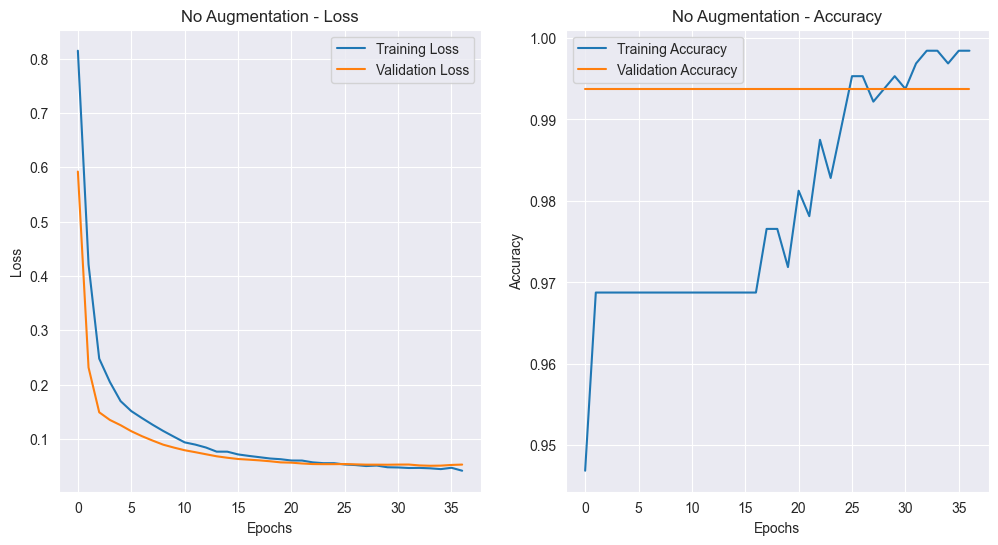

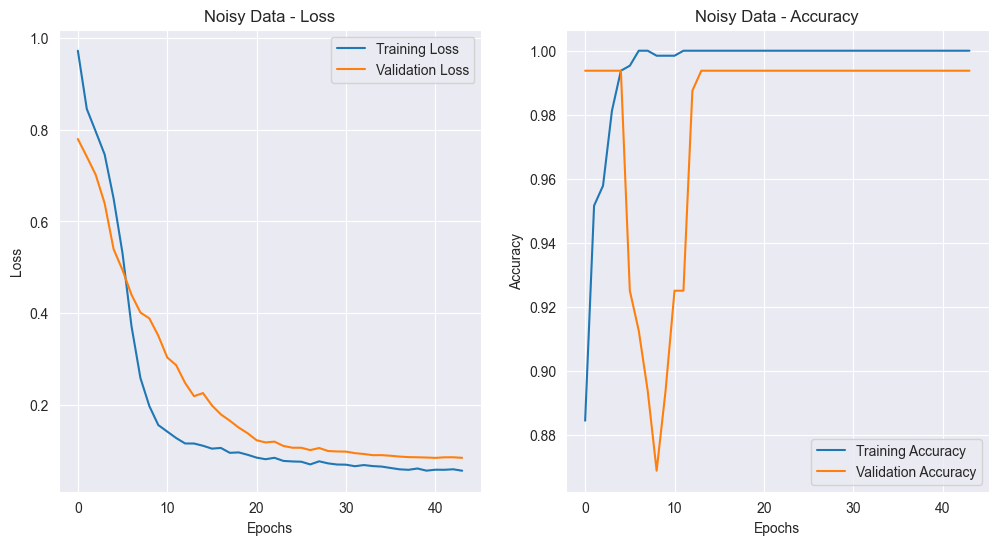

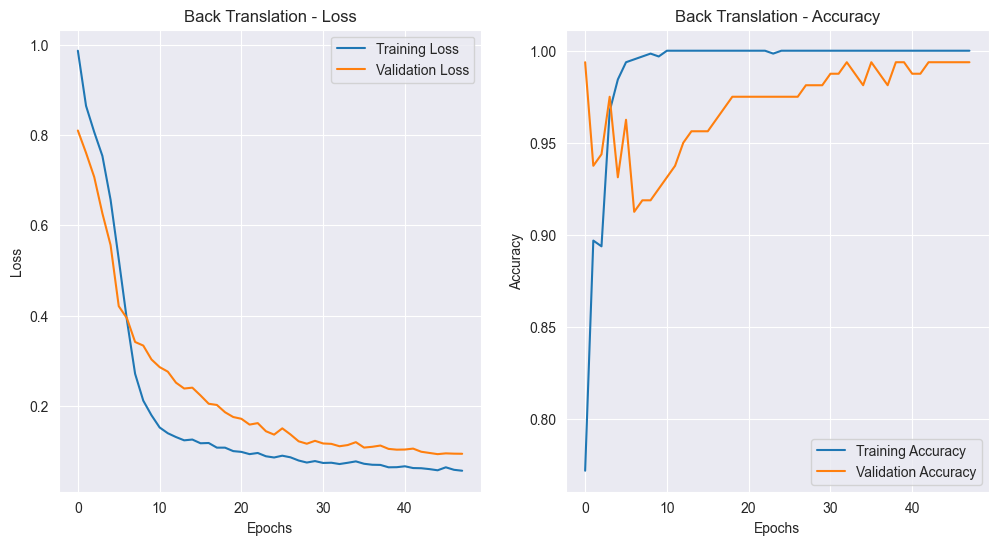

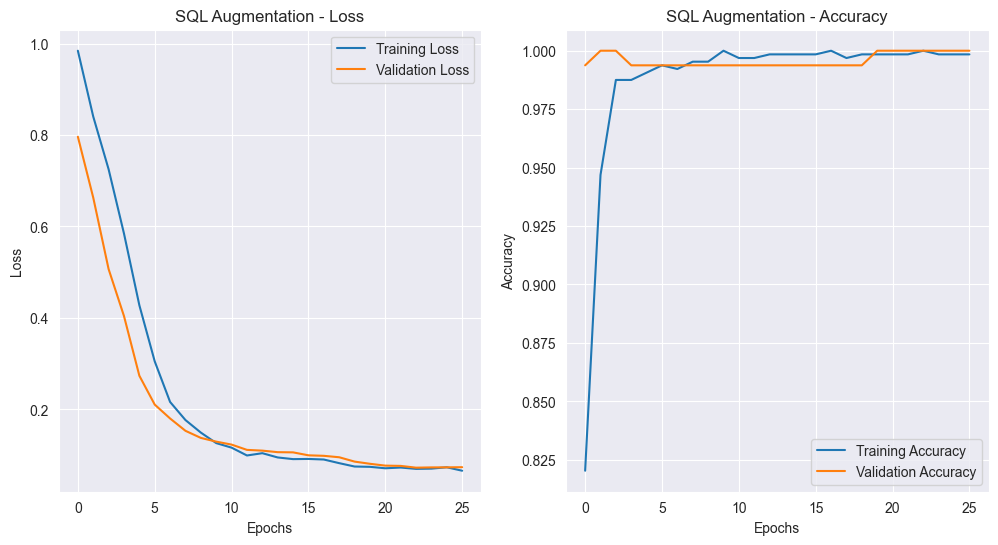

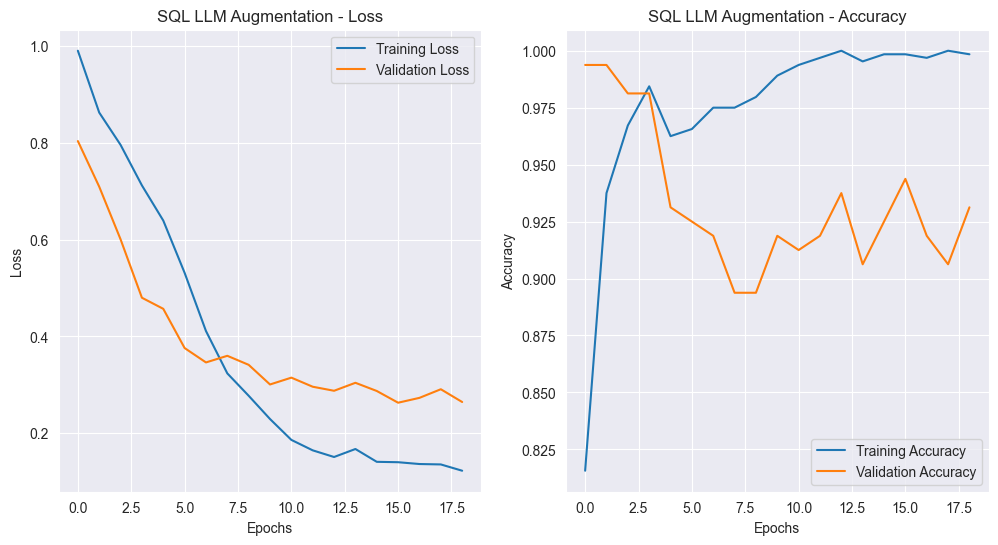

In [39]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    if isinstance(history, dict):
        loss = history['loss']
        val_loss = history['val_loss']
        accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
    else:
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
    
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plot_training_history(history_no_augmentation, "No Augmentation")
plot_training_history(history_noisy, "Noisy Data")
plot_training_history(history_back_translation, "Back Translation")
plot_training_history(history_sql_augmented, "SQL Augmentation")
plot_training_history(history_sql_llm_augmented, "SQL LLM Augmentation")

                      best_val_accuracy  best_val_loss
No Augmentation                 0.99375       0.050360
Noisy Data                      0.99375       0.084288
Back Translation                0.99375       0.093392
SQL Augmentation                1.00000       0.072441
SQL LLM Augmentation            0.99375       0.262854


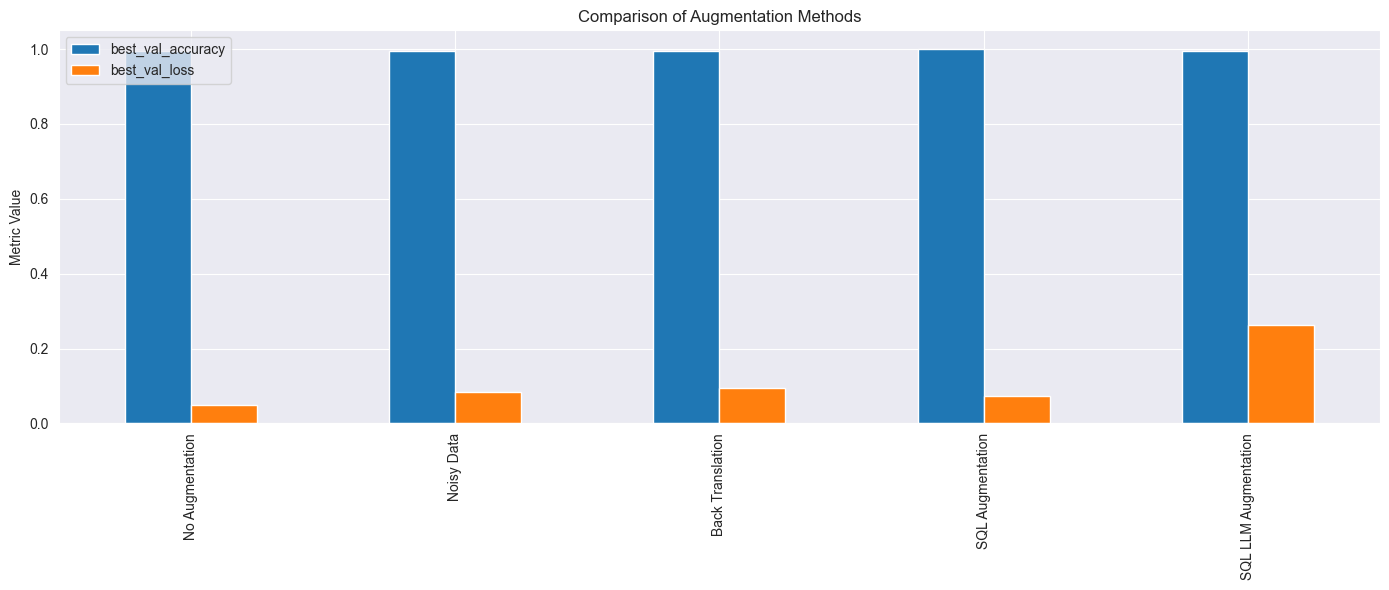

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def get_best_metrics(history):
    return {
        'best_val_accuracy': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss'])
    }

comparison = pd.DataFrame({
    'No Augmentation': get_best_metrics(history_no_augmentation),
    'Noisy Data': get_best_metrics(history_noisy),
    'Back Translation': get_best_metrics(history_back_translation),
    'SQL Augmentation': get_best_metrics(history_sql_augmented),
    'SQL LLM Augmentation': get_best_metrics(history_sql_llm_augmented)
}).T

print(comparison)

comparison.plot(kind='bar', figsize=(14, 6))
plt.title('Comparison of Augmentation Methods')
plt.ylabel('Metric Value')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
from scipy import stats

def compare_models(model1_history, model2_history, model1_name, model2_name):
    model1_accuracy = model1_history.history['val_accuracy']
    model2_accuracy = model2_history.history['val_accuracy']
    
    t_statistic, p_value = stats.ttest_ind(model1_accuracy, model2_accuracy)
    
    print(f"Comparison between {model1_name} and {model2_name}:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print("Significant difference" if p_value < 0.05 else "No significant difference")
    print()

compare_models(history_no_augmentation, history_sql_llm_augmented, "No Augmentation", "SQL LLM Augmentation")
compare_models(history_noisy, history_sql_llm_augmented, "Noisy Data", "SQL LLM Augmentation")
compare_models(history_back_translation, history_sql_llm_augmented, "Back Translation", "SQL LLM Augmentation")
compare_models(history_sql_augmented, history_sql_llm_augmented, "SQL Augmentation", "SQL LLM Augmentation")

Comparison between No Augmentation and SQL LLM Augmentation:
T-statistic: 11.729358509630057
P-value: 1.794506896291954e-16
Significant difference

Comparison between Noisy Data and SQL LLM Augmentation:
T-statistic: 5.153660256415415
P-value: 2.911401074126356e-06
Significant difference

Comparison between Back Translation and SQL LLM Augmentation:
T-statistic: 5.251821486066424
P-value: 1.7792656182885708e-06
Significant difference

Comparison between SQL Augmentation and SQL LLM Augmentation:
T-statistic: 10.07372131693991
P-value: 6.904108716836863e-13
Significant difference


### 1. No Augmentation:
- **Training/Validation Loss**: The loss consistently decreases for both training and validation, indicating effective learning without overfitting. The curves converge, suggesting good generalization to the validation data.
- **Training/Validation Accuracy**: Both accuracy curves steadily increase and converge at a high value (~0.99), reflecting strong model performance on both training and validation datasets.

### 2. Noisy Data:
- **Training/Validation Loss**: The training loss decreases consistently, while the validation loss fluctuates more, particularly during the early epochs, before eventually stabilizing. This indicates initial difficulties in generalizing to noisy data, but the model adjusts over time.
- **Training/Validation Accuracy**: The training accuracy quickly reaches near-perfect levels, while the validation accuracy shows significant fluctuations early on, eventually stabilizing as the model adapts to the noise.

### 3. Back Translation:
- **Training/Validation Loss**: Both losses decrease, but the validation loss diverges significantly from the training loss after the initial epochs, suggesting challenges in generalizing well with this augmentation technique.
- **Training/Validation Accuracy**: The validation accuracy shows considerable fluctuations, indicating inconsistent performance on unseen data when using back translation, despite high training accuracy.

### 4. SQL Augmentation:
- **Training/Validation Loss**: The training and validation losses consistently decrease over the epochs, with the validation loss slightly diverging from the training loss but not as significantly as seen with back translation. This suggests that SQL augmentation is effective in improving model robustness, with the model being able to generalize reasonably well to the validation set.
- **Training/Validation Accuracy**: Both training and validation accuracy curves increase steadily, with the validation accuracy reaching a perfect score of 1.0. This indicates that the SQL augmentation technique successfully enhances the model's ability to generalize across different data samples, leading to optimal performance.

### 5. SQL LLM Augmentation:
- **Training/Validation Loss**: The training loss decreases, but the validation loss fluctuates considerably throughout the training process, which suggests difficulties in generalizing when using LLM-based SQL augmentation. The model may be overfitting to the training data or struggling with the variations introduced by the LLM augmentation.
- **Training/Validation Accuracy**: While the training accuracy increases consistently, the validation accuracy fluctuates significantly across epochs, indicating that the model's performance on unseen data is inconsistent when using this augmentation technique. Despite high training accuracy, the model struggles to maintain stable validation accuracy, which points to potential overfitting or ineffective generalization.

### Conclusion:
The visualizations confirm that SQL Augmentation is the most effective technique among those tested, yielding the best balance between training and validation performance. In contrast, SQL LLM Augmentation, despite showing promise, introduces more variability in the model's ability to generalize, making it less reliable compared to other methods like simple SQL augmentation or even the unaugmented data. These findings can guide the choice of augmentation techniques in future model training tasks, emphasizing the importance of balancing model complexity with generalization capabilities.